# 유튜브 인기 동영상 데이터 분석

!pip install kaggle 

캐글 홈페이지에 로그인 후, 상단 우측에 Your Profile을 클릭 후 컨텍스트 메뉴에서 My Account를 선택한다.  
그리고 다음과 같이 API 란에 'Create New API Token' 버튼을 클릭 하면 kaggle.json 파일이 다운로드 된다.  
이 파일을 User ->사용자에 -> ~/.kaggle/ 폴더에 저장한다.  

--------------------------------------------------------

#### 데이터 준비

캐글에서 진행되고 있는 경진대회 목록을 보여주는 명령어

In [212]:
!kaggle competitions list

ref                                                                               deadline             category            reward  teamCount  userHasEntered  
--------------------------------------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
https://www.kaggle.com/competitions/nfl-player-contact-detection                  2023-03-01 23:59:00  Featured          $100,000        550           False  
https://www.kaggle.com/competitions/godaddy-microbusiness-density-forecasting     2023-03-14 23:59:00  Featured           $60,000       1750           False  
https://www.kaggle.com/competitions/learning-equality-curriculum-recommendations  2023-03-14 23:59:00  Featured           $55,000        524           False  
https://www.kaggle.com/competitions/rsna-breast-cancer-detection                  2023-02-27 23:59:00  Featured           $50,000       1200           False  
https://www.kaggle.com/competitions/icecube-ne

다운받을 수 있는 데이터들의 리스트

In [213]:
!kaggle datasets list

ref                                                             title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ahsan81/hotel-reservations-classification-dataset               Hotel Reservations Dataset                        480KB  2023-01-04 12:50:31           4728        173  1.0              
senapatirajesh/netflix-tv-shows-and-movies                      Latest Netflix TV shows and movies                  1MB  2023-01-14 17:03:12           1289         38  0.88235295       
johnny1994/divorce-rates-data-should-you-get-married            Divorce Rates Data: Should You Get Married?        22KB  2023-01-15 12:49:06            782         31  0.88235295       
rakkesharv/spotify-top-10000-streamed-songs                     Spotif

유튜브 인기영상 다운로드 - YouTube Trending Video Dataset (updated daily)

In [214]:
!kaggle datasets download -d rsrishav/youtube-trending-video-dataset

youtube-trending-video-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


파일을 압축 해제하기

In [215]:
import zipfile
         
fantasy_zip = zipfile.ZipFile('./youtube-trending-video-dataset.zip')
fantasy_zip.extractall('./youtube-trending-video-dataset/')
 
fantasy_zip.close()

#### 아이디어

해당 데이터셋으로 다음에 활용가능한 것들은?

- 다양한 형태의 감정 분석
- 댓글 및 통계를 기반으로 YouTube 동영상을 분류
- RNN과 같은 ML 알고리즘 적용
- YouTube 동영상의 인기도에 영향을 미치는 요인을 분석
- 시간 경과에 따른 통계 분석

#### Columns

- video_id          ->  영상 ID
- title             ->  영상 제목
- publishedAt       ->  업로드 일자
- channelId         ->  채널 ID
- channelTitle      ->  채널 명
- categoryId        ->  카테고리 ID , json 참조
- trending_date     ->  인기영상 일자
- tags              ->  태그
- view_count        ->  조회수
- dislikes          ->  싫어요수
- likes             ->  좋아요수 
- comment_count     ->  댓글수
- thumbnail_link    ->  썸네일 링크
- comments_disabled 
- ratings_disabled
- description       -> 영상소개 더보기

#### 상황


가정

1. 한국에서 유튜브 채널을 시작하려함
2. 채널의 방향을 어떻게 잡아야 인기 동영상에 갈 수 있을지 알아보고자함

궁금한 것

1. 인기 동영상의 기준은 무엇인가
2. 현재 인기동영상의 전반적인 상황은 어떠한가    
    2.1. view_count  
    2.2. likes  
    2.3. comment_count  
    2.4. tag_count  
    2.5. Ratio   
    2.6. title_length  
    2.7. description_length  
    2.8. 하루 평균 인기 동영상의 개수  
    2.9. 게시되고 어느 정도 지나서 인기 영상에 갔는가  
    2.10. category 별 동영상의 수  
    2.11. 채널 별 상황은 어떠한가  
3. 조회수와 연관이 있는 항목들은 무엇인가
4. 결론

---------------------------------------------------------------------------

### 전처리

한글 깨짐 방지

In [323]:
import matplotlib.font_manager as fm

font_list = fm.findSystemFonts(fontpaths = None, fontext = 'ttf')

#한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

라이브러리 불러오기

In [218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import timedelta

data = pd.read_csv('./youtube-trending-video-dataset/KR_youtube_trending_data.csv')


데이터 구성 확인

In [219]:
data.head(3)

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,uq5LClQN3cE,안녕하세요 보겸입니다,2020-08-09T09:32:48Z,UCu9BCtGIEr73LXZsKmoujKw,보겸 BK,24,2020-08-12T00:00:00Z,보겸|bokyem,5947503,53326,105756,139946,https://i.ytimg.com/vi/uq5LClQN3cE/default.jpg,False,False,NaN
1,I-ZbZCHsHD0,부락토스의 계획 [총몇명 프리퀄],2020-08-12T09:00:08Z,UCRuSxVu4iqTK5kCh90ntAgA,총몇명,1,2020-08-12T00:00:00Z,총몇명|재밌는 만화|부락토스|루시퍼|총몇명 프리퀄|총몇명 스토리,963384,28244,494,3339,https://i.ytimg.com/vi/I-ZbZCHsHD0/default.jpg,False,False,"오늘도 정말 감사드립니다!!총몇명 스튜디오 - 총몇명, 십제곱, 5G민, MOVE혁..."
2,9d7jNUjBoss,평생 반성하면서 살겠습니다.,2020-08-10T09:54:13Z,UCMVC92EOs9yDJG5JS-CMesQ,양팡 YangPang,22,2020-08-12T00:00:00Z,양팡|양팡유튜브|팡튜브|가족시트콤|양팡가족|양팡가족시트콤|양팡언니|현실남매|현실자매...,2950885,17974,68898,50688,https://i.ytimg.com/vi/9d7jNUjBoss/default.jpg,False,False,NaN


In [220]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176954 entries, 0 to 176953
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   video_id           176954 non-null  object
 1   title              176954 non-null  object
 2   publishedAt        176954 non-null  object
 3   channelId          176954 non-null  object
 4   channelTitle       176954 non-null  object
 5   categoryId         176954 non-null  int64 
 6   trending_date      176954 non-null  object
 7   tags               176954 non-null  object
 8   view_count         176954 non-null  int64 
 9   likes              176954 non-null  int64 
 10  dislikes           176954 non-null  int64 
 11  comment_count      176954 non-null  int64 
 12  thumbnail_link     176954 non-null  object
 13  comments_disabled  176954 non-null  bool  
 14  ratings_disabled   176954 non-null  bool  
 15  description        172993 non-null  object
dtypes: bool(2), int64(5)

데이터 복사

In [221]:
df = data[:] 

필요없는 칼럼 삭제

In [222]:
#싫어요수의 경우 특정 시점부터 수집이 되지 않아 0이기에 제외
for col in ["dislikes", "thumbnail_link", "comments_disabled", "ratings_disabled"]:
    del df[col] 

video_id가 동영상의 고유값인지 확인해보겠습니다.

In [223]:
df["video_id"].duplicated().value_counts()

True     156639
False     20315
Name: video_id, dtype: int64

데이터 중복값 제거

In [224]:
df = df.drop_duplicates(["video_id"])[:]

동영상이 여러 일자에 인기동영상이 될 경우, 일자별로 데이터가 생겼습니다.  
이번 분석에서는, 해당 기간동안 처음으로 인기동영상이 되었을 때의 데이터로만 분석을 진행하겠습니다.  
중복된 video_id를 제거.  

In [225]:
df["video_id"].duplicated().value_counts()

False    20315
Name: video_id, dtype: int64

category_id와 json 파일을 사용하여 텍스트로 된 category 열을 생성합니다.

In [226]:
id_to_category = {}

with open("./youtube-trending-video-dataset/KR_category_id.json","r") as f:
    id_data = json.load(f)
    for category in id_data["items"]:
        id_to_category[category["id"]] = category["snippet"]["title"]

# id_to_category

df["categoryId"] = df["categoryId"].astype(str)
df.insert(4, "category", df["categoryId"].map(id_to_category))

categoryId가 29번인 영상을 직접 찾아 확인해보니 카테고리가 "비영리/사회운동"이네요.  
category의 결측치를 "Nonprofits & Activism" 으로 채워줍니다.

In [227]:
df["category"].loc[df["category"].isnull() == True] = "Nonprofits & Activism"

C:\Users\bigdata\AppData\Local\Temp\ipykernel_26672\2824784033.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["category"].loc[df["category"].isnull() == True] = "Nonprofits & Activism"


trending_date & publishAt

분석에 사용하기 위하여 trending_date & publishAt을 datetime 형식으로 바꿔줍니다.

In [228]:
# 날짜 형식 변경
df["trending_date"] = df["trending_date"].str[0:10] #
df["publishedAt"] = df["publishedAt"].str[0:19]
df["trending_date"] = pd.to_datetime(df["trending_date"])
df["publishedAt"] = pd.to_datetime(df["publishedAt"])

동영상에 포함된 태그의 개수로 tag_count 열을 생성했습니다.

In [229]:
df["tag_count"] = df["tags"].apply(lambda x : len(x.split("|")) if x != "[none]" else 0)

- 조회수 대비 좋아요 비율
- 조회수 대비 댓글수 비율 

을 알아보기 위하여 변수 생성

In [230]:
df["likes/view_count"] = df["likes"] / df["view_count"]
df["likes/view_count"] = df["likes/view_count"].fillna(0) # nan -> 0
df["likes/view_count"] = df["likes/view_count"].replace(np.inf, 0) # inf -> 0

df["comment_count/view_count"] = df["comment_count"] / df["view_count"]
df["comment_count/view_count"] = df["comment_count/view_count"].fillna(0) # nan -> 0
df["comment_count/view_count"] = df["comment_count/view_count"].replace(np.inf, 0) # inf -> 0

결측값 확인

In [231]:
df.isnull().sum()

video_id                      0
title                         0
publishedAt                   0
channelId                     0
category                      0
channelTitle                  0
categoryId                    0
trending_date                 0
tags                          0
view_count                    0
likes                         0
comment_count                 0
description                 493
tag_count                     0
likes/view_count              0
comment_count/view_count      0
dtype: int64

title의 길이로 title_lenght 열을 생성했습니다.

In [232]:
df["title_length"] = df["title"].apply(lambda x : len(str(x)) if pd.isnull(x) == False  else 0 )

description & description_length

In [233]:
df["description_length"] = df["description"].apply(lambda x : len(str(x)) if pd.isnull(x) == False  else 0 )

treTime-pubTime  
동영상 게시 후 얼마 후에 인기동영상에 갔는지를 의미하는 treTime-pubTime입니다.


In [234]:
df["treTime-pubTime"] = df["trending_date"] - df["publishedAt"] + timedelta(days = 1)

### 분석

#### 1. 인기동영상의 기준은 무엇인가

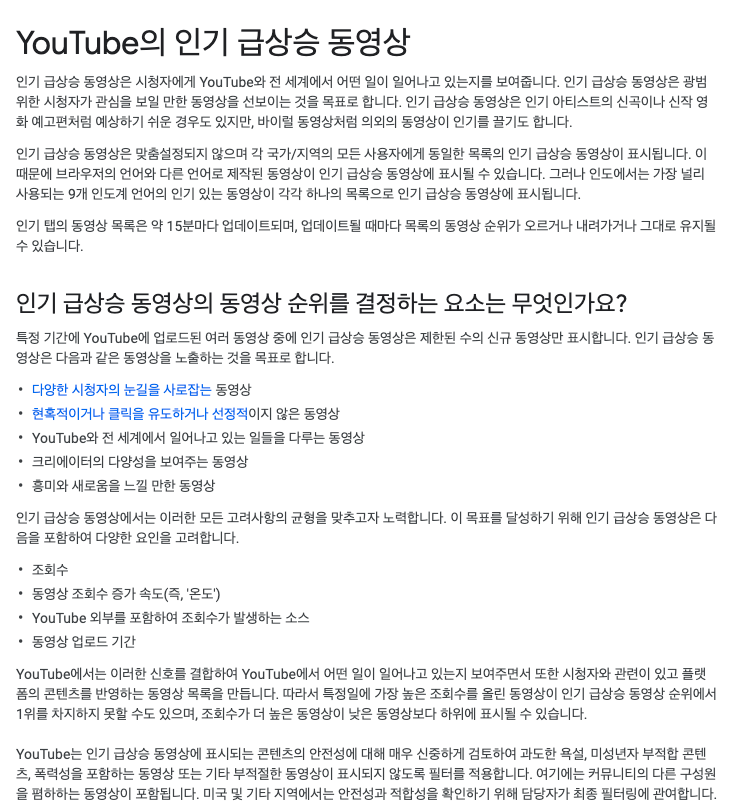

#### 2. 현재 인기 동영상의 전반적인 상황은 어떠한가

In [235]:
print("분석에 사용한 데이터는 {}개의 변수를 가진 인기동영상 데이터 {}개입니다.".format(len(df.columns), format(len(df),",")))

분석에 사용한 데이터는 19개의 변수를 가진 인기동영상 데이터 20,315개입니다.


In [236]:
# 데이터 값 실수. 소수점 두째자리까지 표시
pd.options.display.float_format = '{:.2f}'.format

In [237]:
df.describe()

,view_count,likes,comment_count,tag_count,likes/view_count,comment_count/view_count,title_length,description_length,treTime-pubTime
count,20315.00,20315.00,20315.00,20315.00,20315.00,20315.00,20315.00,20315.00,20315
mean,797132.57,48636.90,5064.44,19.65,0.04,0.00,44.91,392.02,1 days 21:28:28.539896628
std,2188849.90,230211.43,49036.04,19.64,0.05,0.01,22.82,462.13,0 days 23:23:45.613474130
min,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0 days 11:47:11
25%,184570.00,3879.50,394.00,6.00,0.01,0.00,28.00,128.00,1 days 12:29:48
50%,361269.00,7854.00,904.00,14.00,0.02,0.00,42.00,274.00,1 days 14:59:46
75%,732292.00,18434.50,2155.50,27.00,0.04,0.00,59.00,483.00,1 days 20:59:42
max,76805026.00,7110450.00,3400571.00,144.00,0.41,0.16,100.00,4920.00,27 days 14:26:02


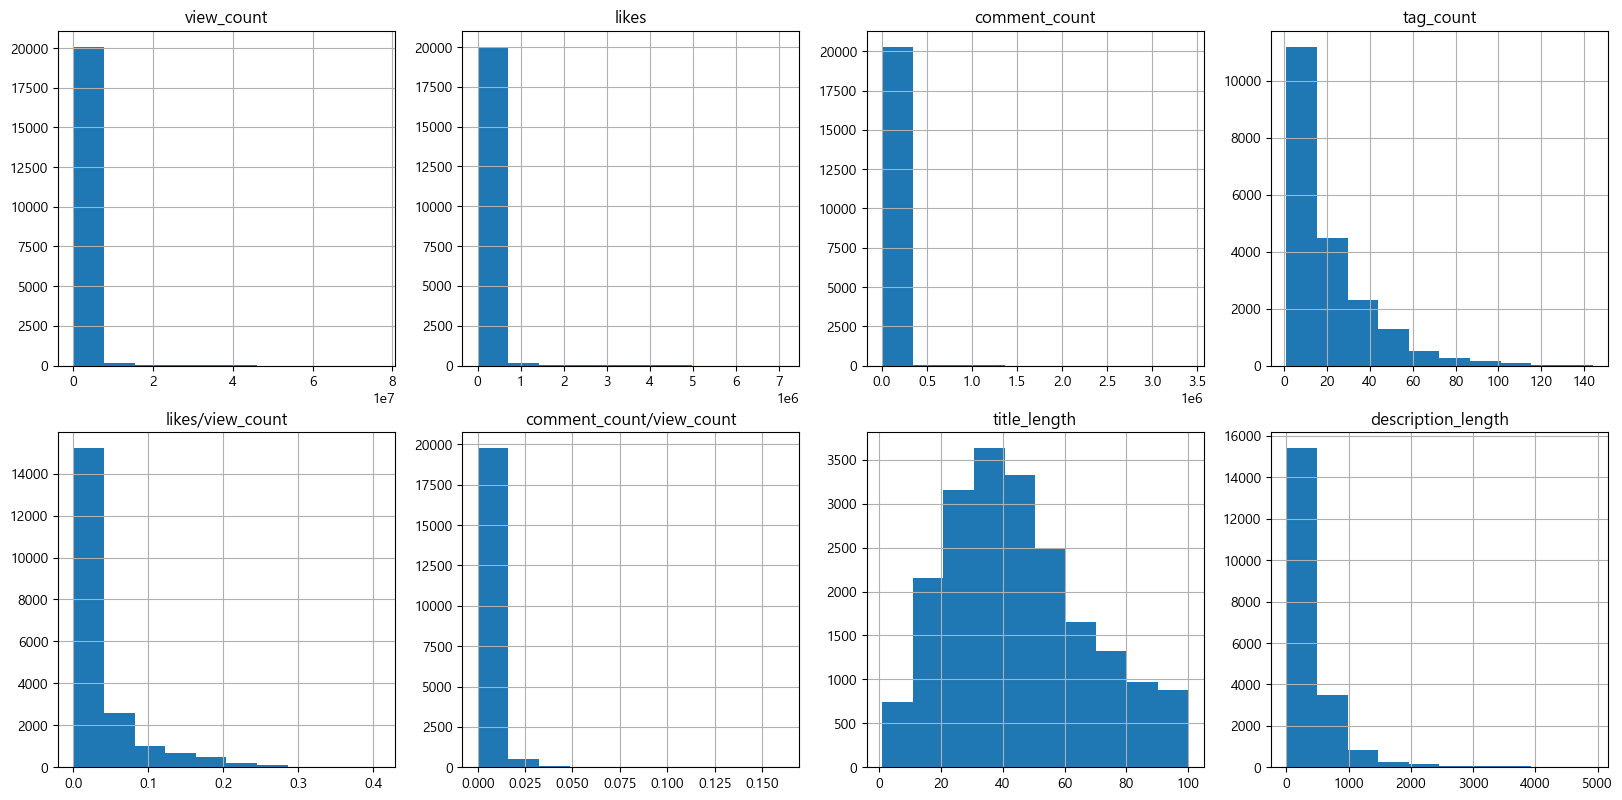

In [238]:
plt.figure(figsize = (20, 20))
for i in range(len(df.describe().columns) - 1 ):
    plt.subplot(4, 4, i + 1)
    plt.title(df.describe().columns[i])
    plt.hist(df[df.describe().columns[i]],bins = 10)
    plt.grid()

수치형 변수의 분포는 전체적으로 오른쪽으로 꼬리가 긴 형태입니다.  
극단적인 케이스의 영향을 많이 받았다고 할 수 있습니다.  

In [315]:
def summary_numeric(col):
    print(col)
    print("평균 {:>15}".format(format(df[col].mean(), ",.2f")))
    print("최소 {:>15}".format(format(df[col].min(), ",.2f")))
    print("중앙 {:>15}".format(format(df[col].median(), ",.2f")))
    print("최대 {:>15}".format(format(df[col].max(), ",.2f")))

In [319]:
# 0을 제외한 summary_numeric 함수
def zero_summary_numeric(col):
    print(col)
    print("평균 {:>15}".format(format(df[col][df[col] != 0].mean(), ",.2f")))
    print("최소 {:>15}".format(format(df[col][df[col] != 0].min(), ",.2f")))
    print("중앙 {:>15}".format(format(df[col][df[col] != 0].median(), ",.2f")))
    print("최대 {:>15}".format(format(df[col][df[col] != 0].max(), ",.2f")))    

##### 2.1 조회수

In [316]:
summary_numeric("view_count")

view_count
평균      797,132.57
최소            0.00
중앙      361,269.00
최대   76,805,026.00


In [320]:
zero_summary_numeric("view_count")

view_count
평균      797,211.05
최소       14,209.00
중앙      361,298.00
최대   76,805,026.00


views는 수치형 변수 중 최대값의 단위가 가장 큰 항목입니다.  
인기 동영상들은 평균 조회수 797,132이네요.  
최대 조회수는 천만 단위인걸로 봐서 극단값들의 영향이 매우 클 것 같습니다.  

In [241]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20315 entries, 0 to 176778
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype          
---  ------                    --------------  -----          
 0   video_id                  20315 non-null  object         
 1   title                     20315 non-null  object         
 2   publishedAt               20315 non-null  datetime64[ns] 
 3   channelId                 20315 non-null  object         
 4   category                  20315 non-null  object         
 5   channelTitle              20315 non-null  object         
 6   categoryId                20315 non-null  object         
 7   trending_date             20315 non-null  datetime64[ns] 
 8   tags                      20315 non-null  object         
 9   view_count                20315 non-null  int64          
 10  likes                     20315 non-null  int64          
 11  comment_count             20315 non-null  int64          
 12  des

조회수 상위 3개를 살펴보겠습니다.

In [242]:
df[["video_id", "title", "channelTitle", "category", "view_count", "likes", "comment_count", "publishedAt", "trending_date"]].sort_values(by = ["view_count"], ascending = [False]).head(3)

,video_id,title,channelTitle,category,view_count,likes,comment_count,publishedAt,trending_date
92,hsm4poTWjMs,Cardi B - WAP feat. Megan Thee Stallion [Offic...,Cardi B,Music,76805026,2820371,270277,2020-08-07 04:00:10,2020-08-12
52585,WMweEpGlu_U,BTS (방탄소년단) 'Butter' Official MV,HYBE LABELS,Music,67111752,7110450,3400571,2021-05-21 03:46:13,2021-05-21
69616,JQxQqdn9dEM,Let's just have fun with your loved ones!😎 #Pe...,BANGTANTV,Music,62125441,4992443,55611,2021-07-30 13:00:02,2021-08-04


1위는 Cardi B - WAP feat. Megan Thee Stallion로 게시된지 5일 후 조회수 76,805,026에 도달했네요.  
2위는 BTS (방탄소년단) 'Butter' Official MV 뮤비고, 게시 하루만에 조회수 67,111,752입니다.  
3위는 BANGTANTV 채널의  Let's just have fun with your loved ones!로 게시 5일 후 조회수 62,125,441입니다.

상위 2개가 방탄소년단의 영상이네요..

상위에 해당하는 데이터는 이 정도로 살펴보고, 극단치들을 제외하여 데이터를 살펴보겠습니다.

In [243]:
print("전체 데이터 {}건".format(len(df)) )
print("1000만이상 {}건 전체의 {:.2f}%".format(len(df.loc[df["view_count"] >= 10000000]),len(df.loc[df["view_count"] >= 10000000]) / len(df) * 100))
print("100만이상 {}건 전체의 {:.2f}%".format(len(df.loc[df["view_count"] >= 1000000]),len(df.loc[df["view_count"] >= 1000000]) / len(df) * 100))
print("100만이하 {}건 전체의 {:.2f}%".format(len(df.loc[df["view_count"] < 1000000]),len(df.loc[df["view_count"] < 1000000]) / len(df) * 100))

전체 데이터 20315건
1000만이상 158건 전체의 0.78%
100만이상 3380건 전체의 16.64%
100만이하 16935건 전체의 83.36%


조회수 100만 이상 16.64%를 제외하고 그래프를 확인해보겠습니다.

조회수 100만 이하 데이터의 평균: 355376.90


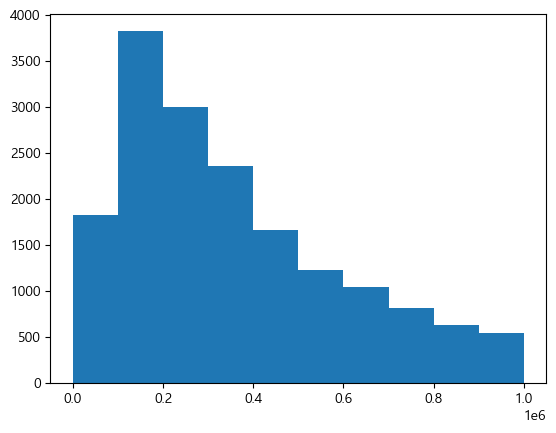

In [244]:
print("조회수 100만 이하 데이터의 평균: {:.2f}".format(df["view_count"].loc[df["view_count"] <= 1000000].mean()))
plt.hist(df["view_count"].loc[df["view_count"] <= 1000000]);

조회수 100만 이상의 데이터를 제외하니,
평균 조회수는 355,376로 나타나고,
조회수 0~20만 이하에 대부분의 영상이 있는 것을 확인할 수 있었습니다.

In [245]:
df.loc[df["view_count"] <= 3000,["video_id", "title", "publishedAt", "trending_date", "category", "view_count", "likes", "comment_count", "tag_count"]].sort_values(by = "view_count")

,video_id,title,publishedAt,trending_date,category,view_count,likes,comment_count,tag_count
24599,gNfxYzW-wME,Hello 2021 Korea | 크리에이터와 함께하는 Goodbye 2020,2020-12-31 14:00:10,2021-01-01,Entertainment,0,2052,627,18
46777,hAxqygRdM4g,Earth Day 2021 Doodle,2021-04-21 11:00:14,2021-04-22,Film & Animation,0,0,0,1


조회수 3천이하의 영상은 2개입니다.  
3천이하로 잡았지만 해당 영상 2개는 조회수가 0인 영상으로, 조회수가 0인데 인기영상에 있는게 이상합니다.    
유튜브에서 발표한 인기영상의 기준을 봤을 때,  
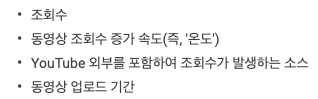  
해당 영상들은 관련 없는것으로 보입니다.
영상을 직접 확인해보니, 플랫폼측에서 임의로 인기영상에 올려둔 것으로 보입니다. (새해영상과 특정기념일때문에)

##### 2.2. likes

In [246]:
df[["video_id", "title", "channelTitle", "category", "view_count", "likes", "comment_count", "tag_count", "description_length"]].sort_values(by = ["likes"], ascending = [False]).head(3)

,video_id,title,channelTitle,category,view_count,likes,comment_count,tag_count,description_length
52585,WMweEpGlu_U,BTS (방탄소년단) 'Butter' Official MV,HYBE LABELS,Music,67111752,7110450,3400571,6,2264
1235,gdZLi9oWNZg,BTS (방탄소년단) 'Dynamite' Official MV,Big Hit Labels,Music,57229275,7046843,2314262,6,1929
2211,vRXZj0DzXIA,BLACKPINK - 'Ice Cream (with Selena Gomez)' M/V,BLACKPINK,Music,51234434,5913495,1848381,26,2730


In [247]:
#describe()
df["likes"].describe()

count     20315.00
mean      48636.90
std      230211.43
min           0.00
25%        3879.50
50%        7854.00
75%       18434.50
max     7110450.00
Name: likes, dtype: float64

간략하게 살펴보면 likes는 평균 48,636, 범위는 0 ~ 7,110,450

상위 3개의 동영상을 살펴보니 모두 뮤직비디오이고,  
52585 항목은 조회수 2위에 해당했던 동영상 입니다.

##### 2.3. comment_count

In [248]:
df[["video_id", "title", "channelTitle", "category","view_count","likes", "comment_count", "tag_count", "description_length"]].sort_values(by = ["comment_count"], ascending = [False]).head(3)

,video_id,title,channelTitle,category,view_count,likes,comment_count,tag_count,description_length
52585,WMweEpGlu_U,BTS (방탄소년단) 'Butter' Official MV,HYBE LABELS,Music,67111752,7110450,3400571,6,2264
1235,gdZLi9oWNZg,BTS (방탄소년단) 'Dynamite' Official MV,Big Hit Labels,Music,57229275,7046843,2314262,6,1929
16757,-5q5mZbe3V8,BTS (방탄소년단) 'Life Goes On' Official MV,Big Hit Labels,Music,37570579,5178787,2267306,6,1384


In [249]:
df['comment_count'].describe()

count     20315.00
mean       5064.44
std       49036.04
min           0.00
25%         394.00
50%         904.00
75%        2155.50
max     3400571.00
Name: comment_count, dtype: float64

comment_count는 평균 5,064, 범위는 0 ~ 3,400,571

##### 2.4. tag_count

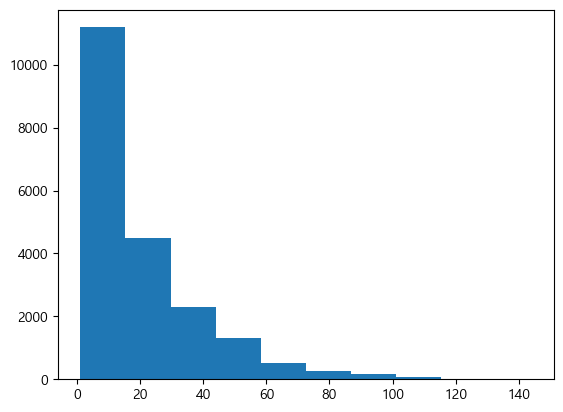

In [250]:
plt.hist(df["tag_count"],bins = 10);

In [251]:
df["tag_count"].describe()

count   20315.00
mean       19.65
std        19.64
min         1.00
25%         6.00
50%        14.00
75%        27.00
max       144.00
Name: tag_count, dtype: float64

tag_count는 평균 19, 범위는 1 ~ 144  
태그의 개수가 10개 이하인 동영상이 10,000개 이상 입니다.

##### 2.5. Ratio (likes/views, comment_count/views)

In [252]:
df[["likes/view_count", "comment_count/view_count"]].describe()

,likes/view_count,comment_count/view_count
count,20315.00,20315.00
mean,0.04,0.00
std,0.05,0.01
min,0.00,0.00
25%,0.01,0.00
50%,0.02,0.00
75%,0.04,0.00
max,0.41,0.16


조회수 대비 좋아요는 평균은 4%이고 최대 41%입니다.  
조회수 대비 댓글수는 대부분 0%인데 최대가 16%네요. 특이값이 있는 것 같습니다.  

In [253]:
df[["video_id", "title", "channelTitle", "category", "view_count", "likes/view_count", "comment_count/view_count", "trending_date"]].sort_values(by = ["likes/view_count"], ascending = [False]).head(5)

,video_id,title,channelTitle,category,view_count,likes/view_count,comment_count/view_count,trending_date
1283,0rUO0pxJKdw,Dynamite (Instrumental),BTS - Topic,Music,727355,0.41,0.01,2020-08-21
2883,CN4fffh7gmk,[CHOREOGRAPHY] BTS (방탄소년단) 'Dynamite' Dance Pr...,BANGTANTV,Music,4299878,0.38,0.02,2020-09-02
8310,v9Zd5R62kCg,BTS (방탄소년단) MAP OF THE SOUL ON:E Teaser 2,Big Hit Labels,Music,2534309,0.38,0.01,2020-10-07
65575,ic8C_cyw84s,D.O. 디오 '공감' Mood Sampler Ver.1,EXO,Music,636395,0.35,0.05,2021-07-15
121563,HbkBVxU5K5A,BTS (방탄소년단) 'Butter' @ The 64th GRAMMY Awards,BANGTANTV,Music,1962446,0.35,0.02,2022-04-23


조회수 대비 좋아요를 기준으로 하는 상위 5개의 항목입니다.  

1위에서 5위까지 5개 영상 전부 Music 카테고리에 해당 영상의 곡들은 BTS 4개 EXO 1개.. 해외팬들의 영향이 큰 것으로 보입니다. 

##### 2.6. title_length

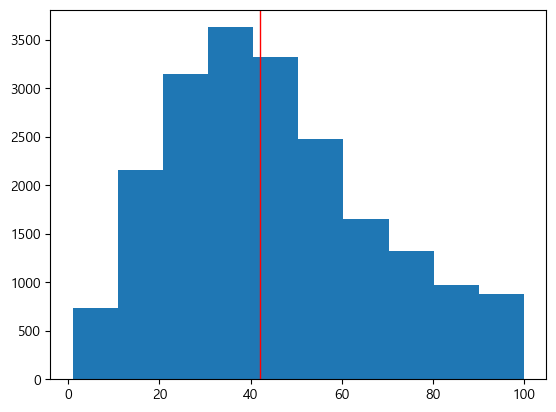

In [254]:
plt.hist(df["title_length"],bins = 10)
plt.axvline(x = 42, color = "r", linestyle = "-", linewidth = 1)

In [255]:
df['title_length'].describe()

count   20315.00
mean       44.91
std        22.82
min         1.00
25%        28.00
50%        42.00
75%        59.00
max       100.00
Name: title_length, dtype: float64

title_length는 평균 44, 범위는 1 ~ 100입니다.  
항목들 중 그나마 극단적으로 치우치지 않은 분포를 보입니다.  
영상 제목 길이가 10~60자 이내인 동영상이 많은 비중을 차지하고 있습니다.  

In [256]:
df.loc[df["title_length"] <= 2]

,video_id,title,publishedAt,channelId,category,channelTitle,categoryId,trending_date,tags,view_count,likes,comment_count,description,tag_count,likes/view_count,comment_count/view_count,title_length,description_length,treTime-pubTime
30,7yuRQjZzGpU,진심,2020-08-09 12:14:51,UChQ-VMvdGrYZxviQVMTJOHg,People & Blogs,도티 TV,22,2020-08-12,도티|도티 마인크래프트|마인크래프트 도티|마인크래프트|마인크래프트 던전스|마인크래프...,1458857,30975,17540,미안하고 감사해요-------------------------------------...,11,0.02,0.01,2,67,3 days 11:45:09
874,ItOBzI6b0AM,꾹뚝,2020-08-17 09:00:09,UCaKod3X1Tn4c7Ci0iUKcvzQ,Entertainment,런닝맨 - 스브스 공식 채널,24,2020-08-18,런닝맨|김종국|유재석|이광수|runningman|RunningMan|Runningm...,658934,9671,1588,김종국X유재석 모음.zip 《런닝맨 / 예능맛ZIP / RunningMan》야!!카...,45,0.01,0.00,2,78,1 days 14:59:51
4062,-771tnJLScs,비밀,2020-09-10 07:57:30,UCFOixeB9gbedVi6uwnsfHMQ,Science & Technology,1분과학,28,2020-09-10,1분과학|과학|도서|다큐|영화|우주|우주다큐,109791,6601,1715,1분과학 책 나왔습니다!!만화로 나와서 아주 후루룩 쉽게 넘어가는 책입니다.사셔서 ...,7,0.06,0.02,2,804,0 days 16:02:30
39985,SvsdftzxyoA,이발,2021-03-18 08:01:09,UChbE5OZQ6dRHECsX0tEPEZQ,Comedy,장삐쭈,23,2021-03-19,[None],1142752,21584,4252,이번주는 휴가로 인한 휴재입니다그냥가기 아쉬워서 짧은거 하나 투척그림 : 안류천편집...,1,0.02,0.00,2,59,1 days 15:58:51
60794,N4bn4rHROFA,ㅎ2,2021-06-19 08:00:11,UCiMq04sS1ijeM0tda9OkuQw,People & Blogs,픽셀,22,2021-06-20,애니메이션|픽셀|픽셀네트워크|픽셀스토어|머그컵|굿즈|탬탬버린|김진우|지누|탬탬|버린...,146043,6171,461,안녕하세요 픽셀스토어입니다.📢6월 25일 금요일 오후 2시부터 김똘복님의 머그컵 굿...,45,0.04,0.00,2,118,1 days 15:59:49
69994,xspFaNJcht4,고백,2021-08-05 08:00:37,UChbE5OZQ6dRHECsX0tEPEZQ,Comedy,장삐쭈,23,2021-08-06,장삐쭈|단편선|이그림체|고백|여사친|남사친|커플|연애|고백연습|연습|전화|통화,948407,26101,2776,"그림, 편집 : 안류천더빙 : 장삐쭈",12,0.03,0.00,2,20,1 days 15:59:23
71211,Dsb9h49z-f4,👀,2021-08-10 13:40:26,UCt9a_qP9CqHCNwilf-iULag,Sports,PSG - Paris Saint-Germain,17,2021-08-12,paris saint-germain|psg|paris|football|PSG|PAR...,1135266,81902,4770,👀🔴🔵🎥 Subscribe to the Paris Saint-Germain chan...,34,0.07,0.00,1,167,2 days 10:19:34
75160,8SKcemYNhWo,인사,2021-08-30 12:54:23,UC9sKsado8YOC8J52g6yu4Tw,Comedy,가나쌍둥이Ghana Twins,23,2021-09-01,[None],384440,11891,398,NaN,1,0.03,0.00,2,0,2 days 11:05:37
76554,lQm4xEHOHkM,학생,2021-09-07 09:01:09,UC9sKsado8YOC8J52g6yu4Tw,Comedy,가나쌍둥이Ghana Twins,23,2021-09-08,[None],382726,16038,610,NaN,1,0.04,0.00,2,0,1 days 14:58:51
81367,IF45OB-RmCw,피자,2021-10-01 10:15:02,UCT3CumbFIJiW33uq0UI3zlg,Howto & Style,고기남자 MeatMan,26,2021-10-02,피자|칩|chip|씬피자|피자만들기|고기남자|피자에어프라이어|밥피자|만두피자|화덕피...,204115,5489,1390,피자칩 ...,16,0.03,0.01,2,1259,1 days 13:44:58


제목의 길이가 2인 인기동영상 25개입니다.  
특이한 점은 likes/views 평균이 0.03인 것을 고려했을 때, 25개의 동영상 모두 likes/views의 비율이 높은 편인 것입니다.  

##### 2.7. description_length

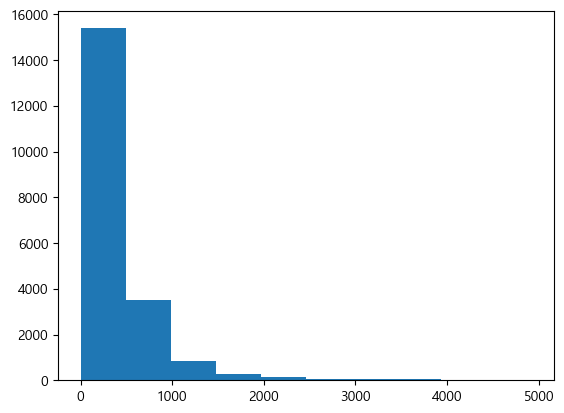

In [257]:
plt.hist(df["description_length"],bins = 10);

In [258]:
df['description_length'].describe()

count   20315.00
mean      392.02
std       462.13
min         0.00
25%       128.00
50%       274.00
75%       483.00
max      4920.00
Name: description_length, dtype: float64

description_length는 평균 392, 범위는 0 ~ 4920  
길이가 500 이하인 데이터가 대부분입니다.  

In [259]:
df[["video_id", "title", "channelTitle", "category", "view_count", "likes", "comment_count", "tag_count", "description_length"]].sort_values(by = ["description_length"], ascending = [False]).head(10)

,video_id,title,channelTitle,category,view_count,likes,comment_count,tag_count,description_length
429,T3p7iEf-Lo8,댓글에 대한 답변과 향후 계획에 대해 드릴 말씀이 있습니다.,디렉터 파이,People & Blogs,213882,5003,1481,1,4920
1415,BYn8M-tk88k,BTS (방탄소년단) 'Dynamite' Official MV 🧨💜 SISTERS ...,sillypak,People & Blogs,123260,11261,1056,33,4894
73977,mglxbnccbeo,오늘도 '생수' 마셨는데…알고보니 수질 '부적합'/[신선미의 똑똑한 소비자 리포트]...,한국경제TV뉴스,News & Politics,88067,1171,399,67,4858
5455,lAOk49dlwnE,최강욱 대권후보로 만들어라 무섭게 올라오는 3등정당의 미래가 보인다는 박시영 도사,KBS더라이브,News & Politics,123468,7272,457,30,4852
153561,jQGIv5Jekzc,돈스파이크? 버닝썬? 평범한 일반인들이 마약에 중독되고 있다! 특히 젊은이들 사이에...,KBS시사,News & Politics,918464,8244,5107,36,4835
7118,56UjWV_x18w,MBN 뉴스파이터-보이스트롯 준우승 김다현 김봉곤 훈장 딸 아닌 김다현 아버지라 불...,MBN News,News & Politics,341449,4711,457,9,4834
13151,8EpcKXbkmcU,BTS - Dynamite (방탄소년단 다이너마이트) | One Voice Chil...,One Voice Children's Choir,Music,801074,56019,4590,21,4792
155180,Sp6BS-rSr98,Charlie Puth - Loser (Official Music Video),Charlie Puth,Music,1200107,91670,4712,29,4755
80955,3YqPKLZF_WU,Coldplay X BTS - My Universe (Official Video),Coldplay,Music,9182529,2247385,209859,27,4722
82577,Z5-6wbdbgA4,"김밥의 수많은 속재료가 부담된다면? '이것'만 준비하세요, 간단하게 김밥 맛집 흉내...",백종원의 요리비책 Paik's Cuisine,People & Blogs,366736,5993,246,14,4707


대부분 뉴스, 음악 영상들로 보인다.   
뉴스의 경우에는 기자, 엥커의 내용을 영상소개에 넣고, 여러가지 링크를 같이 적어 길이가 길어진것으로 보이고,  
음악의 경우는 노래가사를 영상소개에 적고, 각종 SNS링크등을 추가해서 길이가 길어진것으로 보인다.  

82577 백종원 채널의 경우는 여러 요리 만드는법을 적어두어 영상 소개 길이가 길어진것으로 보인다.   

##### 2.8. 하루 평균 인기 동영상의 개수

In [272]:
# # data["trending_date"] yyyy-mm-dd 형식으로 변경 T뒤로 삭제
data["trending_date"] = data["trending_date"].str.split("T", expand = True)[0]
# data["trending_date"] 날짜 타입으로 변경
data["trending_date"] = data["trending_date"].astype("datetime64")

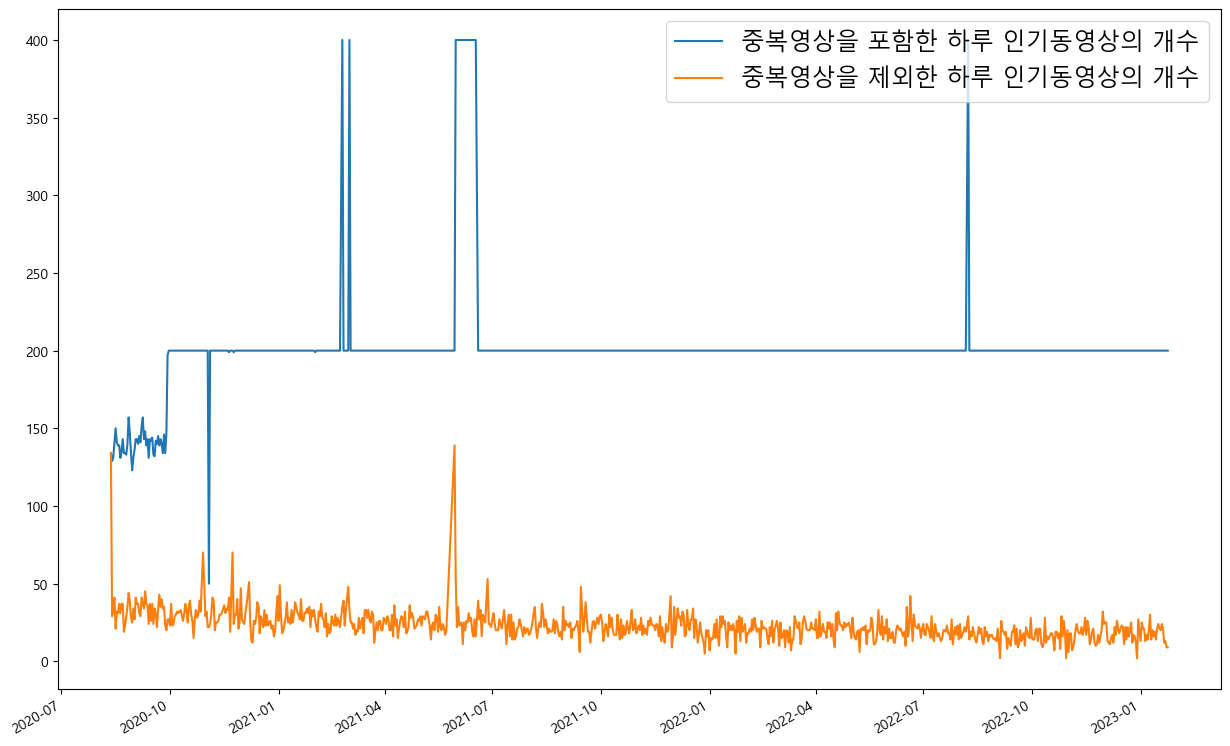

In [278]:
plt.figure(figsize = (15,10));
data["trending_date"].value_counts().plot(label = "중복영상을 포함한 하루 인기동영상의 개수")
df["trending_date"].value_counts().plot(label = "중복영상을 제외한 하루 인기동영상의 개수")

plt.legend(prop = {"size":17});

In [263]:
print("중복영상을 포함한 하루 인기동영상의 개수")
print("평균 : {:.2f}개".format(data["trending_date"].value_counts().mean()))
print("최대 : {:.2f}개".format(data["trending_date"].value_counts().max()))
print("최소 : {:.2f}개".format(data["trending_date"].value_counts().min()))

print("중복영상을 제외한 하루 인기동영상의 개수")
print("평균 : {:.2f}개".format(df["trending_date"].value_counts().mean()))
print("최대 : {:.2f}개".format(df["trending_date"].value_counts().max()))
print("최소 : {:.2f}개".format(df["trending_date"].value_counts().min()))

중복영상을 포함한 하루 인기동영상의 개수
평균 : 201.31개
최대 : 400.00개
최소 : 50.00개
중복영상을 제외한 하루 인기동영상의 개수
평균 : 23.11개
최대 : 139.00개
최소 : 2.00개


##### 2.9. 게시되고 어느 정도 지나서 인기 영상에 갔는가

In [279]:
df["treTime-pubTime"].describe()

count                        20315
mean     1 days 21:28:28.539896628
std      0 days 23:23:45.613474130
min                0 days 11:47:11
25%                1 days 12:29:48
50%                1 days 14:59:46
75%                1 days 20:59:42
max               27 days 14:26:02
Name: treTime-pubTime, dtype: object

인기동영상들은 동영상을 평균적으로 게시하고 다음 날 인기동영상이 되었습니다.   
빠르면 당일에 인기동영상이 되네요.

In [288]:
pd.cut(df["treTime-pubTime"],[timedelta(days = 0),timedelta(days = 1),timedelta(days = 2),timedelta(days = 3),timedelta(days = 27)]).value_counts(sort = False,normalize = True)

(0 days 00:00:00, 1 days 00:00:00]    0.07
(1 days 00:00:00, 2 days 00:00:00]    0.73
(2 days 00:00:00, 3 days 00:00:00]    0.12
(3 days 00:00:00, 27 days 00:00:00]   0.08
Name: treTime-pubTime, dtype: float64

게시 후  
당일에 인기동영상이 되는 경우가 3%  
2일째에 인기동영상이 되는 경우가 90%  
3일 이내에 인기동영상이 되는 경우가 95%입니다.   
게시 후 3일 이내에 인기동영상이 되지 못하면, 인기 동영상이 되기 힘들다고 보입니다.

In [289]:
df.loc[df["treTime-pubTime"] > timedelta(days = 27)].sort_values(by = "treTime-pubTime", ascending = False) 

,video_id,title,publishedAt,channelId,category,channelTitle,categoryId,trending_date,tags,view_count,likes,comment_count,description,tag_count,likes/view_count,comment_count/view_count,title_length,description_length,treTime-pubTime
160228,sMfMXJ6dX0k,大S徐熙媛&具俊曄 愛如初見｜202210 封面人物｜Vogue Taiwan,2022-10-06 09:33:58,UCKl0gSq0JOcdzXTrS4gk2cg,Entertainment,VOGUE Taiwan,24,2022-11-02,VOGUE|voguetaiwan|CNE-TW|大S|具俊曄,298138,4764,188,熙媛牽著具俊曄的手抵達攝影棚，笑盈盈地跟攝影師說：「嗨，好久不見，跟你介紹一下，這是我的新老...,5,0.02,0.00,39,1128,27 days 14:26:02


게시 후 27일이 지나 인기동영상이 된 사례입니다.

해당 영상은 VOGUE Taiwan채널의 화보영상으로 구준엽과 대만의 시위안의 결혼소식에 의해 인기영상에 오른것으로 보인다.

##### 2.10. category 별 동영상의 수

In [290]:
print("전체 데이터 {}개\ncategory 개수 {}개\n".format(len(df),len(df["category"].unique())))
for i in range(len(df["category"].value_counts())):
    print("{:23} {:4} {:.2f}".format(df["category"].value_counts().index[i], 
                            df["category"].value_counts().values[i],
                            df["category"].value_counts(normalize = True).values[i]))

전체 데이터 20315개
category 개수 15개

Entertainment           7029 0.35
People & Blogs          3063 0.15
Music                   2262 0.11
Sports                  1713 0.08
News & Politics         1213 0.06
Comedy                  1169 0.06
Gaming                   809 0.04
Howto & Style            766 0.04
Film & Animation         617 0.03
Education                388 0.02
Pets & Animals           372 0.02
Travel & Events          328 0.02
Science & Technology     327 0.02
Autos & Vehicles         223 0.01
Nonprofits & Activism     36 0.00


category 별 인기동영상의 개수를 확인해본 결과입니다.  
1위는 Entertainment로 7029개 35%  
2위는 People & Blogs(VLOG)로 3063개 15%  
3위는 Music로 2262개 11%  

3개의 카테고리가 60%를 차지하네요.  
위의 3가지 카테고리에 속한 카테고리를 사람들이 많이 조회한다고 보입니다.  

In [291]:
for cate in df["category"].value_counts().index[0:3]:
    print(cate, df["treTime-pubTime"].loc[df["category"] == cate].mean())

Entertainment 1 days 22:16:05.281263337
People & Blogs 1 days 21:31:14.885732941
Music 1 days 23:41:47.946507515


3개 카테고리 모두 평균 1일만에 인기동영상이 되네요.

##### 2.11. 채널 별 상황은 어떠한가

In [293]:
print("전체 데이터 개수 {} 포함된 채널의 수 {}".format(len(df), len(df["channelTitle"].unique())))

전체 데이터 개수 20315 포함된 채널의 수 3247


In [296]:
df_pivot=pd.pivot_table(df, index = ["channelTitle"], 
                    values = ["view_count"],
                    aggfunc = ["count", "mean"])

1     0.37
2     0.16
3     0.09
4     0.07
5     0.05
      ... 
76    0.00
146   0.00
99    0.00
53    0.00
92    0.00
Name: view_count, Length: 78, dtype: float64

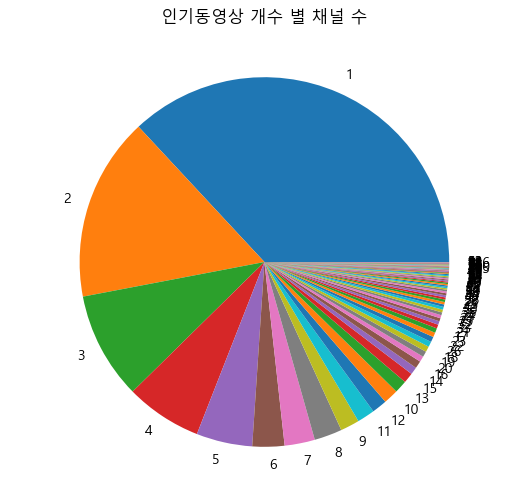

In [301]:
df_pivot["count"]["view_count"].value_counts().plot(kind = "pie",title = "인기동영상 개수 별 채널 수",label = " ",figsize = (6, 6));
# 퍼센트로 나타내기
df_pivot["count"]["view_count"].value_counts(normalize = True)

해당 기간 동안 인기동영상 개수 별 채널의 수입니다.  
인기 동영상을 1개 보유한 채널이 약 37%이고, 3개 이내가 약 62%입니다.

In [304]:
df["category"].loc[df["channelTitle"].isin(df_pivot[df_pivot["count"]["view_count"] == 1].index)].value_counts()

Entertainment            269
People & Blogs           239
Music                    181
Gaming                    87
Howto & Style             74
Sports                    58
News & Politics           52
Film & Animation          49
Education                 43
Comedy                    37
Pets & Animals            35
Science & Technology      24
Autos & Vehicles          24
Travel & Events           22
Nonprofits & Activism      5
Name: category, dtype: int64

인기동영상 개수가 1개인 채널의 카테고리 현황입니다.  
Entertainment, People & Blogs 의 비중이 각각 1,2위입니다.  
Sports 카테고리는 생각보다 작은 6위이네요.  

In [305]:
df["category"].loc[df["channelTitle"].isin(df_pivot[(df_pivot["count"]["view_count"] >= 2) & (df_pivot["count"]["view_count"] < 4)].index)].value_counts()

Entertainment            565
People & Blogs           384
Music                    220
Sports                   131
Gaming                   127
Comedy                    96
News & Politics           76
Film & Animation          69
Pets & Animals            62
Howto & Style             62
Education                 59
Science & Technology      45
Autos & Vehicles          29
Travel & Events           20
Nonprofits & Activism     11
Name: category, dtype: int64

인기동영상 개수가 2~3개인 채널의 카테고리 현황입니다.  
마찬가지로 Entertainment, People & Blogs의 비중이 각각 1,2위입니다.  
Sports 카테고리는 두단계 상승하여 4위이네요

In [306]:
df["category"].loc[df["channelTitle"].isin(df_pivot[df_pivot["count"]["view_count"] >= 4].index)].value_counts()

Entertainment            6195
People & Blogs           2440
Music                    1861
Sports                   1524
News & Politics          1085
Comedy                   1036
Howto & Style             630
Gaming                    595
Film & Animation          499
Education                 286
Travel & Events           286
Pets & Animals            275
Science & Technology      258
Autos & Vehicles          170
Nonprofits & Activism      20
Name: category, dtype: int64

인기동영상 개수가 4개 이상인 채널의 카테고리 현황입니다.  
이전의 결과들과 다르게 News & Politics 카테고리가 꽤 많이 올라왔습니다.  
Entertainment 와 People & Blogs는 여전히 1,2위를 차지했네요. 

인기동영상 개수별 채널 현황 및 카테고리를 살펴보니 인기동영상을 3개 이내로 보유한 채널이 전체의 60%였고,
4번 이상 보유한 채널들의 동영상들을 살펴봤을 때, News & Politics 카테고리가 생각보다 많이 올라왔습니다.

Entertainment 카테고리의 동영상을 다루는 채널들은 모든 범위에서 인기동영상에 많이 선정된다고 보이고,
People & Blogs, Music, Sports, News & Politics, Comedy 카테고리들이 주류라고 보여집니다.                  

#### 3. 조회수와 연관이 있는 항목들은 무엇인가

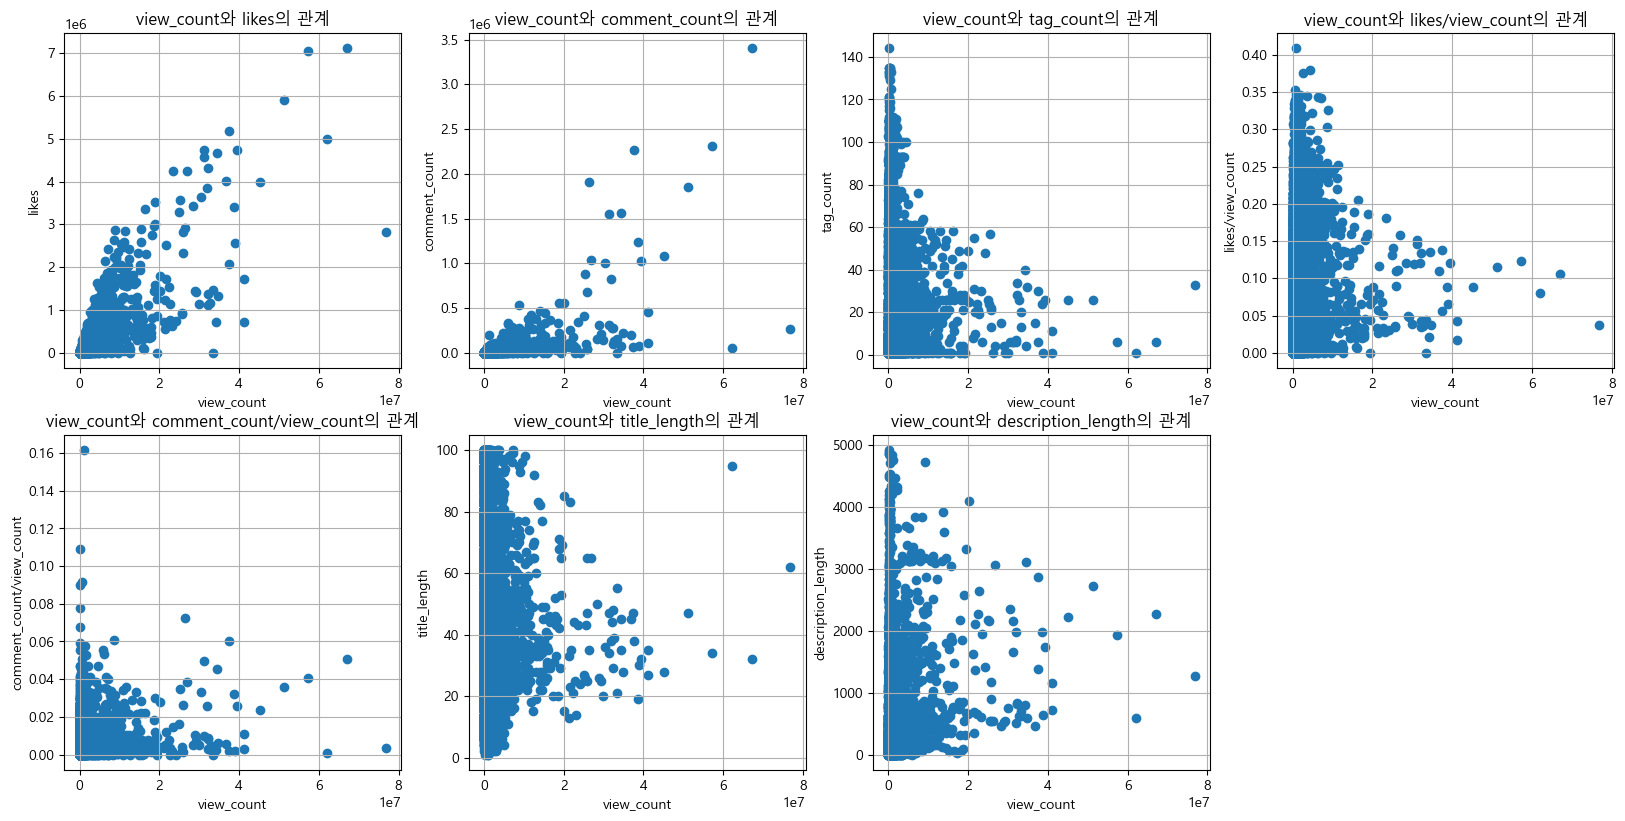

In [324]:
plt.figure(figsize = (20, 20))

for i in range(1, len(df.describe().columns) - 1 ):
    plt.subplot(4, 4, i)
    plt.title("view_count와 {}의 관계".format(df.describe().columns[i]))
    plt.xlabel("view_count")
    plt.ylabel(df.describe().columns[i])
    plt.scatter(x = df["view_count"], y = df[df.describe().columns[i]])
    plt.grid()

조회수에 영향을 주는 항목들이 무엇인지 알아보기 위한 산점도입니다.  
소수의 조회수 상위 항목들에 의해 그래프의 분포가 영향을 받는 것 같습니다.  
조회수 상위 데이터(조회수 백만 이상 데이터)를 제외하고 그래프를 그려보겠습니다.  

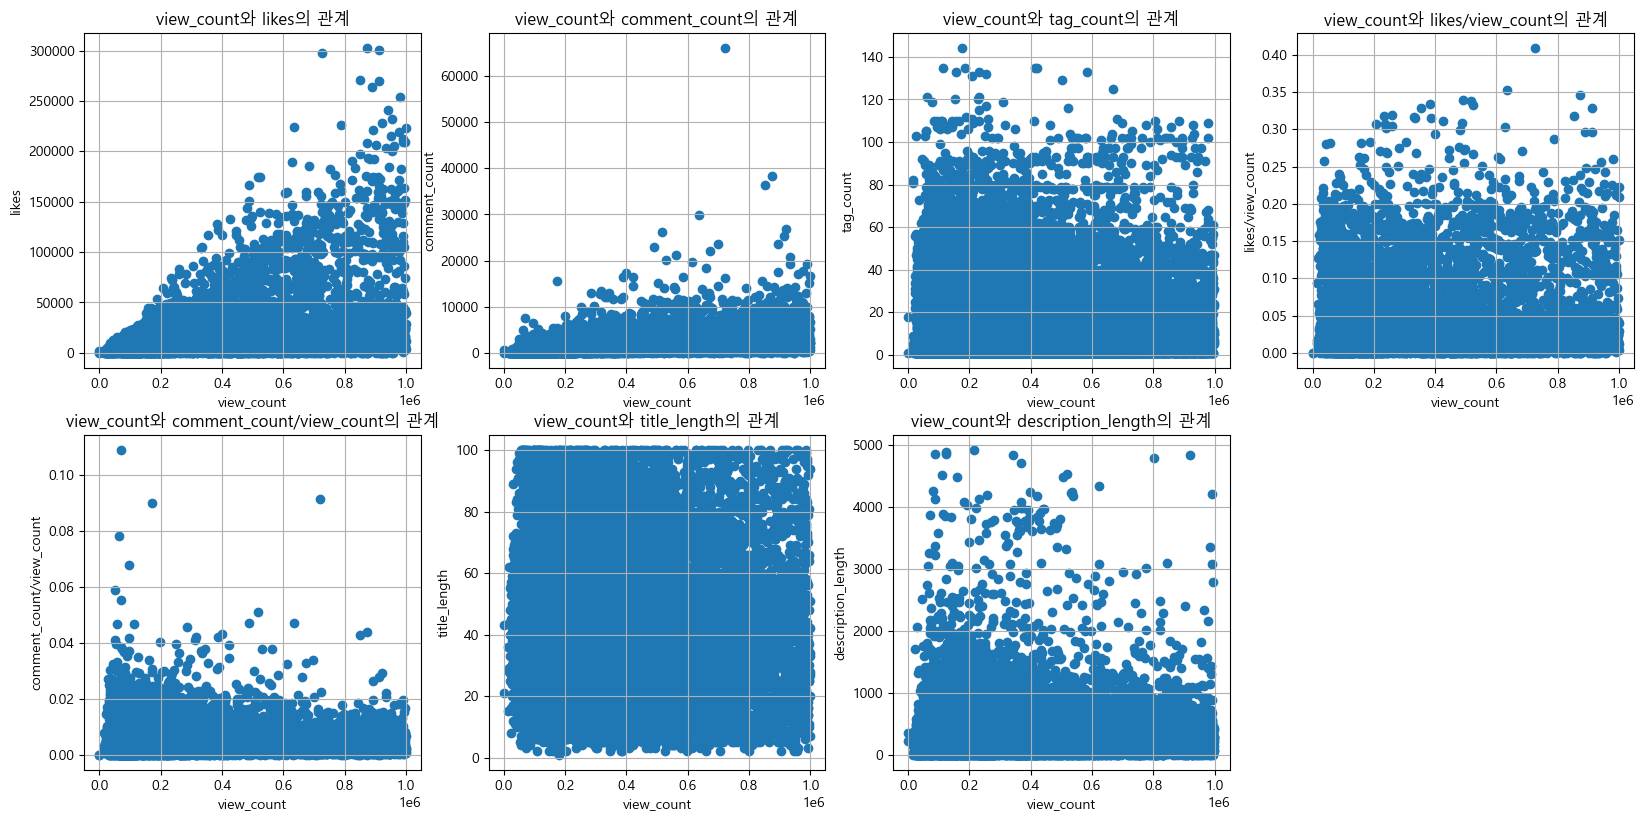

In [309]:
plt.figure(figsize = (20, 20))

for i in range(1, len(df.describe().columns) - 1 ):
    plt.subplot(4, 4, i)
    plt.title("view_count와 {}의 관계".format(df.describe().columns[i]))
    plt.xlabel("view_count")
    plt.ylabel(df.describe().columns[i])
    plt.scatter(x = df["view_count"].loc[df["view_count"] <= 1000000], y = df[df.describe().columns[i]].loc[df["view_count"] <= 1000000])
    plt.grid()

C:\Users\bigdata\AppData\Local\Temp\ipykernel_26672\3018259500.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data = df.loc[df["view_count"] <= 1000000].corr(method="pearson"), annot = True, fmt = ".2f", linewidths = .5, cmap = "Blues");


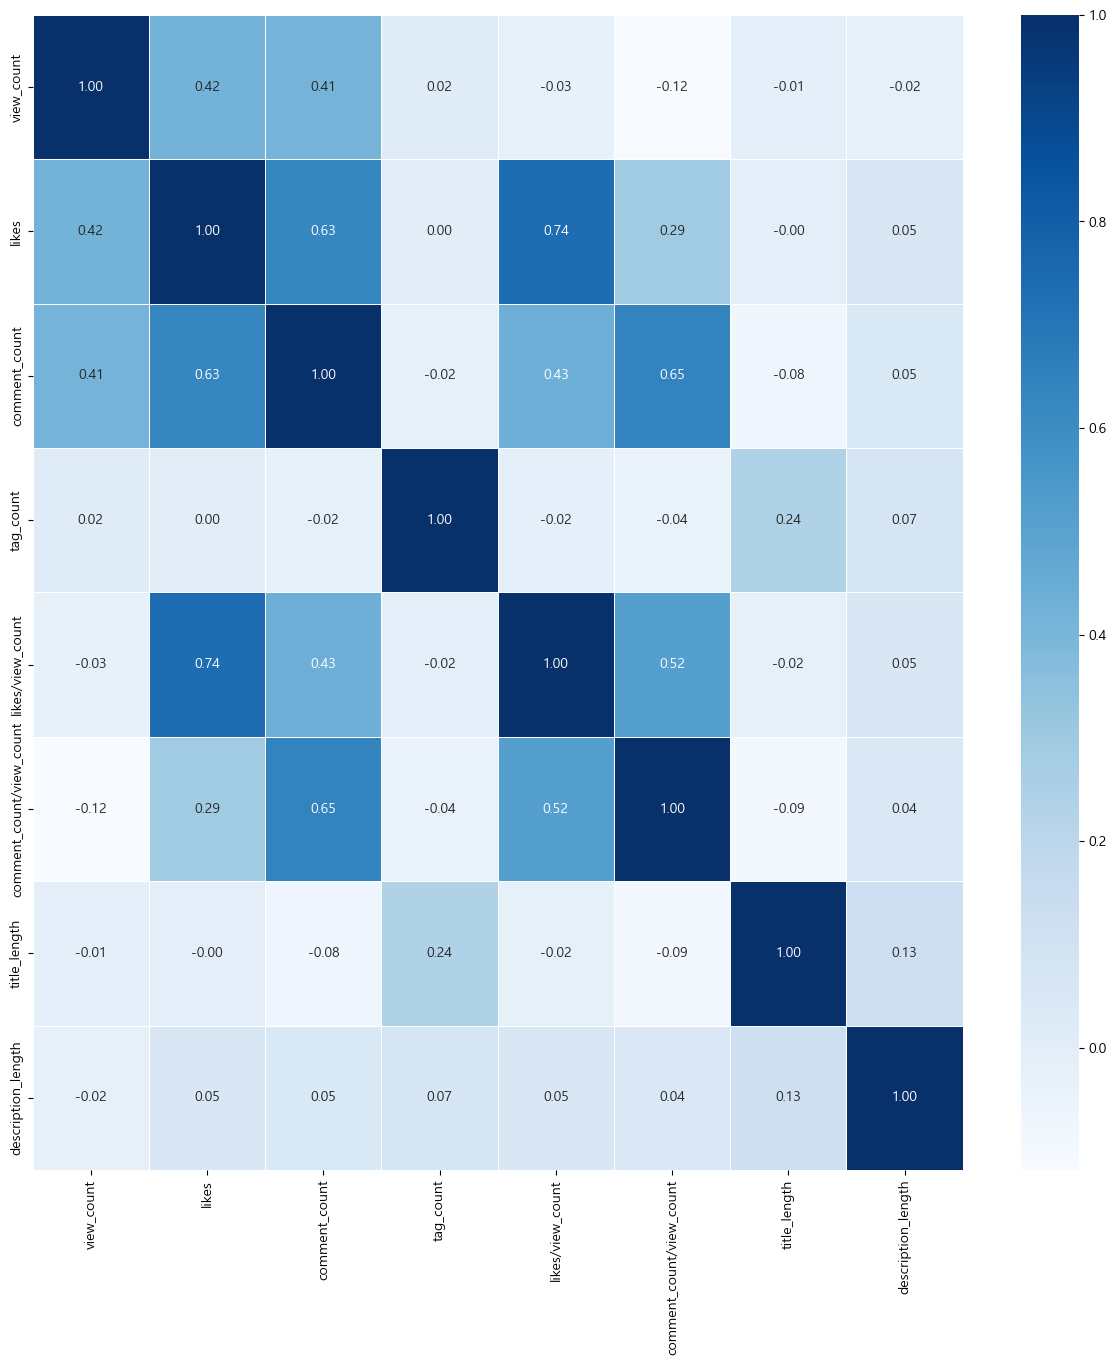

In [310]:
plt.figure(figsize = (15,15))
sns.heatmap(data = df.loc[df["view_count"] <= 1000000].corr(method="pearson"), annot = True, fmt = ".2f", linewidths = .5, cmap = "Blues");

조회수 상위 데이터를 제외한 상관관계입니다.  
likes, comment_count가 각각 0.42, 0.41의 상관관계를 가진다고 나타났습니다.    
다만 좋아요를 누르거나 댓글을 남기려면 먼저 동영상을 조회해야하기 때문에,  
조회수가 likes, comment_count에 영향을 준다고 해석해야 합니다.  

tag_count, title_length, description_length가 views와 상관관계가 있지 않을까 생각했었는데, 관계가 없는 것으로 나타났습니다.

#### 4. 결론

지금까지 인기 동영상들의 전반적인 상황을 살펴봤습니다.  
분석의 목적인 "채널의 방향을 어떻게 잡아야 인기 동영상에 갈 수 있나"를 고려했을 때,   
시사점은 다음과 같습니다.  

##### 시사점

인기동영상에 게시된 동영상들은 조회수 20만 이하의 영상이 대부분이고, 조회수가 가장 적은 영상은 14,209이다.
3일 이내에 인기동영상이 되지 못하면, 인기 동영상이 되기 힘들다고 보인다.  
인기 동영상의 60%는 Entertainment, People & Blogs, Music 의 카테고리에 속한다.  
Entertainment 카테고리 동영상을 다루는 채널들은, 채널 별 인기동영상의 개수를 기준으로 보면, 모든 범위에서 많은 비중을 차지한다.  

##### 전략

1. 채널은 Entertainment, People & Blogs, Music의 3개 카테고리의 동영상을 다뤄야하며, 그 중에서 Entertainment 카테고리가 가장 유리함.
2. 태그 개수는 조회수와 크게 상관이 없는 것으로 보이나, 대부분의 인기동영상은 10개 정도 사용함.
3. 제목의 길이는 조회수와 크게 상관이 없는 것으로 보이나, 대부분의 인기동영상은 10~60자 정도의 제목을 사용함.
4. 설명의 길이는 조회수와 크게 상관이 없는 것으로 보이나, 대부분의 인기동영상은 500자 이내의 설명을 사용함.
5. 3일 이내로 조회수 최소 14,000을 넘기지 못했다면 다음 동영상을 준비해야함.